<a href="https://colab.research.google.com/github/booleto/dissonance-calculator/blob/main/dissonance_calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import json
import soundfile as sf
from scipy.io import wavfile
from scipy.fftpack import fft
from google.colab import files
import matplotlib.pyplot as plt

In [ ]:
def dissmeasure(fvec, amp, model='min'):
    """
    Calculates the dissonance of a collection of tones.
    :param fvec: vector of frequencies
    :param amp: vector of amplitudes
    :param model: 'product' or 'min', type of amplitude interaction
    :return: dissonance value
    """

    # Sort by frequency
    sort_idx = np.argsort(fvec)
    am_sorted = np.asarray(amp)[sort_idx]
    fr_sorted = np.asarray(fvec)[sort_idx]

    # Used to stretch dissonance curve for different freqs:
    Dstar = 0.24  # Point of maximum dissonance
    S1 = 0.0207
    S2 = 18.96

    C1 = 5
    C2 = -5

    # Plomp-Levelt roughness curve:
    A1 = -3.51
    A2 = -5.75

    # Truncate negative frequencies:
    min_idx = find_min_abs_index(fr_sorted)
    np.delete(fr_sorted, np.s_[0:min_idx])
    np.delete(am_sorted, np.s_[0:min_idx])

    # Generate all combinations of frequency components
    idx = np.transpose(np.triu_indices(len(fr_sorted), 1))
    fr_pairs = fr_sorted[idx]
    am_pairs = am_sorted[idx]

    Fmin = fr_pairs[:, 0]
    S = Dstar / (S1 * Fmin + S2)
    Fdif = fr_pairs[:, 1] - fr_pairs[:, 0]

    if model == 'min':
        a = np.amin(am_pairs, axis=1)
    elif model == 'product':
        a = np.prod(am_pairs, axis=1)  # Older model
    else:
        raise ValueError('model should be "min" or "product"')
    
    SFdif = S * Fdif
    D = np.sum(a * (C1 * taylor_exp(A1 * SFdif) + C2 * taylor_exp(A2 * SFdif)) * 1e-37)

    return D

def find_min_abs_index(arr):
    abs_arr = np.abs(arr)
    min_index = np.argmin(abs_arr)
    return min_index

def exp_pade(x):
    x = np.asarray(x)
    n = x.shape[0]
    c = np.array([1/2, 1/12, 1/720])
    d = np.array([1/6, 1/120])
    num = np.ones(n)
    den = np.ones(n)
    for i in range(3):
        num += c[i] * x**(2*i+1)
        den += d[i] * x**(2*i+2)
    return num / den

def taylor_exp(x, n_terms=10):
    """
    Approximate the exp function using a truncated Taylor series expansion.

    Parameters:
    x: numpy array
        The input values for which to compute the exp function.
    n_terms: int
        The number of terms to use in the Taylor series expansion.

    Returns:
    numpy array
        The approximated values of the exp function for the input values.
    """
    result = np.zeros_like(x)
    factorial = 1
    power = np.ones_like(x)
    
    for i in range(n_terms):
        result += power / factorial
        power *= x
        factorial *= (i + 1)
    
    return result

In [ ]:
def calculate_dissonance(sound_file, segment_size):
    """
    Calculates the dissonance of each segment in a sound file.
    :param sound_file: path to sound file
    :param segment_size: size of each segment in samples
    :return: array of dissonance values for each segment
    """
    # Read sound file
    data, sample_rate = sf.read(sound_file)
    print(data.shape)

    # Convert stereo to mono if necessary
    if len(data.shape) > 1:
        data = np.mean(data, axis=1)

    # Split data into segments
    num_segments = data.shape[0] // segment_size
    segments = np.split(data[:num_segments*segment_size], num_segments)

    # Calculate dissonance for each segment
    dissonance_values = []
    for segment in segments:
        # Apply FFT to segment
        freq_data = fft(segment)

        # Calculate frequency and amplitude vectors
        freqs = np.fft.fftfreq(segment.size, 1/sample_rate)
        amps = 2/segment.size * np.abs(freq_data)

        # Calculate dissonance for segment
        dissonance_values.append(dissmeasure(freqs, amps))

    return np.array(dissonance_values)

Saving In-the-morning-Jazz-Glory_320kbps.mp3 to In-the-morning-Jazz-Glory_320kbps.mp3
(1630412, 2)
[ 10.12101515  32.68377661  21.85171483 ... 328.55356196 156.0779108
  41.59383246]


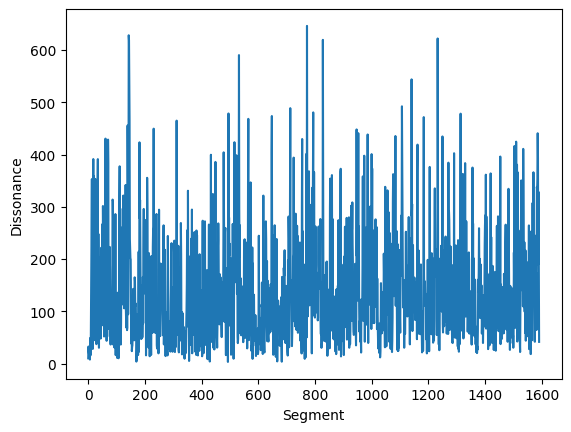

In [ ]:
# Prompt user to upload sound file
uploaded_file = files.upload()
sound_file_name = list(uploaded_file.keys())[0]
#sound_file_name = "In-the-morning-Jazz-Glory_320kbps.wav"

# Calculate dissonance values for sound file with segment size of 1024 samples
dissonance_values = calculate_dissonance(sound_file_name, 1024)
print(dissonance_values)

# Plot dissonance values
plt.plot(dissonance_values)
plt.xlabel('Segment')
plt.ylabel('Dissonance')
plt.show()

In [ ]:
# Convert the numpy array to a list
dissonance_list = dissonance_values.tolist()

# Save the list to a JSON file
with open('dissonance_list.json', 'w') as f:
    json.dump(dissonance_list, f)

# Download the JSON file
files.download('dissonance_list.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Dissonance function demonstration:
frequencies = np.array([1, 2, 3, 4, 5, 6])
frequencies = np.append(frequencies, frequencies ** 1.05)
print(frequencies)
amplitudes = np.array([1, 0.5, 0.333, 0.25, 0.2, 0.167, 1, 0.5, 0.333, 0.25, 0.2, 0.167])
dissonance = dissmeasure(frequencies, amplitudes)
print(dissonance)

[1.         2.         3.         4.         5.         6.
 1.         2.07052985 3.16940193 4.28709385 5.41899193 6.56234129]
3.8284104873763565
